# Final Project Submission

* Student name: `Reno Vieira Neto`
* Student pace: `self paced`
* Scheduled project review date/time: `Fri Oct 15, 2021 3pm – 3:45pm (PDT)`
* Instructor name: `James Irving`
* Blog post URL: https://renoneto.github.io/using_streamlit

# Table of Contents <a class="anchor" id="toc"></a>
- **[Business Case and Goals](#bc)**
- **[The Dataset](#td)**
- **[Dataset Exploration and Cleaning](#dec)**
  - **[No. of Movies by Genre](#mg)**
  - **[No. of Ratings per Year](#ry)**
  - **[No. of Users rating movies per Year](#urm)**
- **[Recommender System](#rs)**
  - **[Create Popularity Model](#pop)**

# Business Case and Goal <a class="anchor" id="bc"></a>
In this project, I'm creating a movie recommender using the [MovieLens dataset](https://grouplens.org/datasets/movielens/) to build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies. I'm going to be addressing the cold start problem as well by being able to deal with users with no movie ratings.

# The Dataset <a class="anchor" id="td"></a>
The MovieLens dataset is a "classic" recommendation system dataset used in numerous academic papers and machine learning proofs-of-concept.

[You can find more about it here](https://grouplens.org/datasets/movielens/)

# Dataset Exploration and Cleaning <a class="anchor" id="dec"></a>
## Import necessary packages 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from surprise import Reader, Dataset, dump
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import KNNBasic, KNNBaseline, SVD, SVDpp
from surprise.accuracy import rmse
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
# Import datasets
df_movies = pd.read_csv('./app/data/movies.csv')
df_ratings = pd.read_csv('./app/data/ratings.csv')

In [4]:
# Show first rows
display(df_movies.head())
display(df_ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### Notes
- Breakdown genres into different columns (one-hot encoding)
- `title` seems to have the release year of the movie. It might be interesting to have title and year in different columns.

In [5]:
# Check for nulls and data types
display(df_movies.info())
display(df_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

#### Notes
- No nulls
- Might need to convert timestamps to `datetime`
- There are 9742 movies in the dataset
- 100836 ratings

### `df_movies`
First, I'm going to start exploring the movies dataset to understand what I'm dealing with.

In [8]:
# Create column with array of genres and calculate the Number of Genres per movie
df_movies['genres_array'] = df_movies['genres'].str.split('|')

# Flattened genres
stacked_genres = df_movies['genres_array'].apply(pd.Series).stack(level=0).reset_index()
stacked_genres.columns = ['index', 'level_1', 'genre']

# Combine original dataframe with flattened genres using the index
df_movies_new = pd.merge(df_movies, stacked_genres, how='left', left_index=True, right_on=['index'])
df_movies_new = df_movies_new[['movieId', 'title', 'genre']]

In [9]:
# One-hot Encoding of Genre column
one_hot = pd.get_dummies(df_movies_new['genre'])

# Get list of genres (it's going to be useful soon)
list_of_genres = list(one_hot.columns)

# Combine the new dataframe with the one-hot encoded dataframe
df_movies_new = pd.merge(df_movies_new, one_hot, left_index=True, right_index=True)
df_movies_new = df_movies_new.drop('genre', axis=1)

# Use groupby to have one row per movie
df_movies_new = df_movies_new.groupby(['movieId', 'title']).sum()[list_of_genres].reset_index()

In [10]:
# Split year and title
df_movies_new['release_year'] = df_movies_new.apply(lambda x: x['title'].strip()[-5:][:-1], axis=1)
df_movies_new['release_year'] = df_movies_new.apply(lambda x: 
                                                    x['release_year'] 
                                                    if len(re.findall("[0-9]{4}", x['release_year'])) == 1 
                                                    else np.nan, axis=1)
df_movies_new['title'] = df_movies_new.apply(lambda x: 
                                             x['title'][:-6].strip()
                                             if x['release_year'] != np.nan
                                             else x['title'], axis=1)

### No. of Movies by genre <a class="anchor" id="mg"></a>

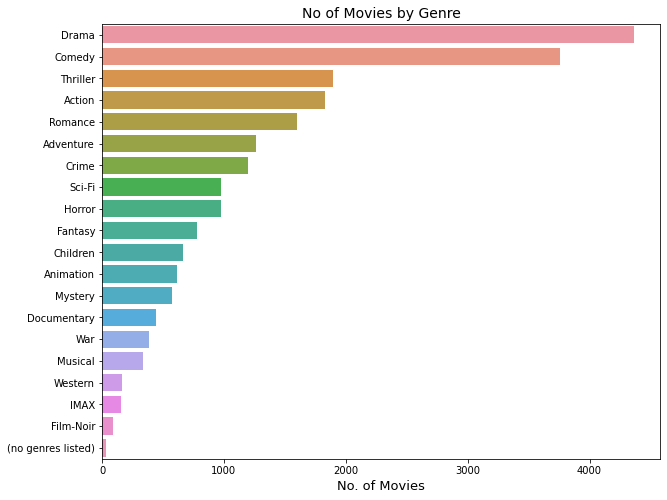

In [8]:
# Create empty dictionary to store the no of movies by genre
no_of_movies_by_genre = {}

for genre in list_of_genres:
    no_of_movies = df_movies_new[genre].sum()
    no_of_movies_by_genre[genre] = no_of_movies
    
# Transform that into a dataframe
to_plot = pd.DataFrame.from_dict(no_of_movies_by_genre, orient='index').reset_index()
to_plot.columns = ['genre', 'no_of_movies']
to_plot = to_plot.sort_values('no_of_movies', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x="no_of_movies", y="genre", data=to_plot)
plt.title('No of Movies by Genre', size=14)
plt.xlabel('No. of Movies', size=13)
plt.ylabel(None)
plt.show()

#### Note
- We are dealing with an unbalanced dataset from the perspective of the genres. There are way more Drama and Comedy movies than other genres. The consequence of that to the model is that certain genres will have a smaller set of options to choose from.

### `df_ratings`
### No. of Ratings per Year <a class="anchor" id="ry"></a>
I wonder how many ratings were created per year.

In [11]:
# Convert timestamp column to datetime
df_ratings['datetime'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings['year'] = df_ratings['datetime'].dt.year

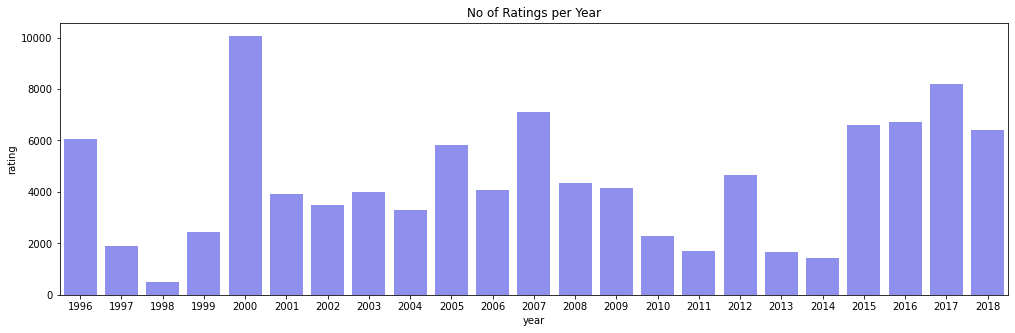

In [12]:
# Create plot with No. of ratings per year
to_plot = df_ratings.groupby('year').count()['rating'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='rating', data=to_plot, color='blue', alpha=0.5)
plt.title('No of Ratings per Year')
plt.show()

**Note**
- I don't see any trends. It's great to see that the last 4 years of the dataset had almost the same number of ratings.

### No. of Users rating movies per Year <a class="anchor" id="urm"></a>

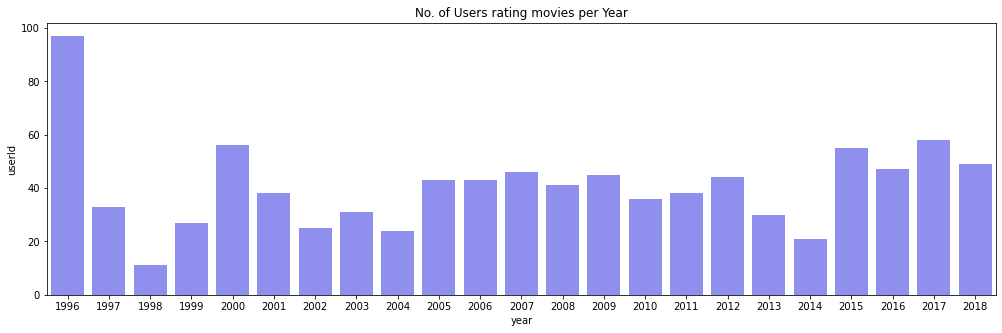

In [14]:
# Create Plot with No. of Unique Users giving ratings
to_plot = df_ratings.groupby('year').nunique()['userId'].reset_index()
plt.figure(figsize=(17,5))
sns.barplot(x='year', y='userId', data=to_plot, color='blue', alpha=0.5)
plt.title('No. of Users rating movies per Year')
plt.show()

**Note**
- Not many users rating movies. Around 40 per year.

# Recommender System <a class="anchor" id="rs"></a>
## Create Popularity Model <a class="anchor" id="pop"></a>
The first model is going to be very simple. It's a popularity model. Basically I'm going to rank movies by popularity. However, I need to find a way to scale the ratings because a movie with 100 ratings with an average of 4.5 and another with 2 with an average of 4.75 are completely different. I'd argue that the first movie actually has a higher rating score than the second one since more users have rated it with a high score. 

To address that problem I'm using the IMDB's Weighted Rating Method I found [online](https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website) that does a good job at weighting the ratings.

#### Calculation
![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

#### C: Calculate mean vote across the whole dataset

In [16]:
# Calculate Mean and Count the No. of Ratings to a given movie
mean_ratings_df = df_ratings.groupby('movieId').agg(avg_rating=('rating', 'mean'), 
                                                count_rating=('rating', 'count')).reset_index()
# Calculate the Overall Average Rating
mean_ratings_df['overall_avg_rating'] = mean_ratings_df['avg_rating'].mean()
mean_ratings_df.head()

,movieId,avg_rating,count_rating,overall_avg_rating
0,1,3.920930,215,3.262448
1,2,3.431818,110,3.262448
2,3,3.259615,52,3.262448
3,4,2.357143,7,3.262448
4,5,3.071429,49,3.262448


#### m: Define the minimum number of ratings required to be listed
To define the minimum number of votes I'm going to look at the distribution of No. of Ratings by Movies.

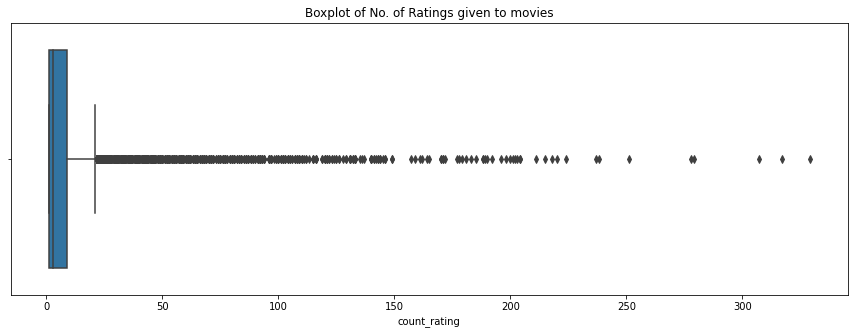

In [17]:
# Plot
plt.figure(figsize=(15,5))
sns.boxplot(x=mean_ratings_df['count_rating'])
plt.title('Boxplot of No. of Ratings given to movies')
plt.show()

Not super helpful. I'm going to print different quantiles

In [18]:
# Calculate different quatiles
n_of_users = df_ratings['userId'].nunique()
n_of_movies = len(mean_ratings_df)
quantiles_list = []

for n in range(10, 100, 5):
    q = mean_ratings_df['count_rating'].quantile(n/100)
    n_of_selected_movies = len(mean_ratings_df[mean_ratings_df['count_rating'] >= q])
    quantiles_list.append([n, q, n_of_selected_movies])

pd.DataFrame(quantiles_list, columns=['quantile', 'quantile_value', 'number_of_movies'])

,quantile,quantile_value,number_of_movies
0,10,1.0,9724
1,15,1.0,9724
2,20,1.0,9724
3,25,1.0,9724
4,30,1.0,9724
5,35,1.0,9724
6,40,2.0,6278
7,45,2.0,6278
8,50,3.0,4980
9,55,3.0,4980


Before deciding the Minimum No. of Ratings, I'm going to look at the number of movies users have rated. 

In [19]:
df_ratings.groupby('userId').count()['movieId'].describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: movieId, dtype: float64

The Median number of movies a user has rated is 70 movies and the 75th quantile is 168 movies. 

Therefore, I'm comfortable moving forward with having the Minimum Number of Ratings (or `m`) of 47 ratings since that represents 491 Movies which is more than most users have rated.

> **Disclamer**: I have tried a minimum of 27/17 ratings as well, however, the model resulted in weird recommendations. So I'm picking 47 after iteratively trying 17 and 27.

#### m = 47

#### Create function to apply to the dataset

In [20]:
def weighted_rating(df):
    """
    Calculates the IMDB's Weighted Rating using the following formula:
        (v / (v+m) * R) + (m / (m+v) * C)
    
    where:
    - v is the number of votes for the movie;
    - m is the minimum votes required to be listed in the chart;
    - R is the average rating of the movie; And
    - C is the mean vote across the whole report
    """
    v = df['count_rating']
    m = df['minimum_no_of_ratings']
    R = df['avg_rating']
    C = df['overall_avg_rating']
    
    return (v / (v+m) * R) + (m / (m+v) * C)

# Create Copy
popularity_df = mean_ratings_df.copy()

# Calculate the 95th quantile and the weighted rating
popularity_df['minimum_no_of_ratings'] = popularity_df['count_rating'].quantile(0.95)
popularity_df['weighted_rating'] = popularity_df.apply(weighted_rating, axis=1)

I'm going to look at the top 10 movies with the highest ratings.

In [21]:
# Grab the top 10 ids
top_ten_ids = popularity_df.sort_values('weighted_rating', ascending=False)['movieId'][:10].values

# Print them
for idx, movie_id in enumerate(top_ten_ids):
    print((idx + 1), df_movies[df_movies['movieId'] == movie_id]['title'].item())

1 Shawshank Redemption, The (1994)
2 Fight Club (1999)
3 Godfather, The (1972)
4 Star Wars: Episode IV - A New Hope (1977)
5 Pulp Fiction (1994)
6 Matrix, The (1999)
7 Schindler's List (1993)
8 Usual Suspects, The (1995)
9 Forrest Gump (1994)
10 Star Wars: Episode V - The Empire Strikes Back (1980)


Not too bad, I agree with these being the top 10. _However, that's very personal._

## Collaborative-Based Filtering

Collaborative Filtering is based on the idea that users similar to a me can be utilized to predict how much I will like a particular product or service that those same users have used/experienced but I have not.

The strategy is to use different models and compare their performances. The metric to optimize for is RMSE. However, most likely, the best model will be the Singular Value Decomposition (SVD) or SVD++ based on what I have seen in different places. Nonetheless, I think it's worth trying different models rather than simply trying only these two models.

Moreover, I'm also considering the fit time, otherwise, I might end up with a model that would not be _deployable_.

In [22]:
# Create a new dataframe to train the model.
df_ratings_clean = df_ratings[['userId', 'movieId', 'rating']]

#### Reduce dataset to decrease runtime

The dataset is too big and it's going to take too long to train the models if I use the whole dataset (_I've learned that the hard way_). Therefore, I'm picking only 50% of it to identify the best hyperparameters for the SVD model and I'm running GridSearchCV only for 50% of that. Once I identify the best hyperparameters, I'll then train the model using the whole dataset.

In [23]:
# Randomly pick 50,000 datapoints fmor the dataset
sample_df = df_ratings_clean.sample(n=50000, random_state=111)

# Split the sample data in two so I can test the best hyperparameters later on
train_df, test_df = train_test_split(sample_df, train_size=.50, random_state=111)

# Create reader and dataset objects
reader = Reader()
traindata = Dataset.load_from_df(train_df, reader)
testdata = Dataset.load_from_df(test_df, reader)

### GridSearchCV - Hyperparameter Tunning of SVD

In [24]:
# Perform a gridsearch with SVD
param_grid = {'n_factors':[10, 15, 20]
              , 'n_epochs': [10, 20]
              , 'lr_all': [0.008, 0.012]
              , 'reg_all': [0.06, 0.1]
              , 'random_state': [111]}

gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=False)

%time gs_model.fit(traindata)

CPU times: user 29.9 s, sys: 228 ms, total: 30.2 s
Wall time: 30.7 s


In [25]:
print('The best parameters are:')
gs_model.best_params['rmse']

The best parameters are:


{'n_factors': 10,
 'n_epochs': 20,
 'lr_all': 0.008,
 'reg_all': 0.1,
 'random_state': 111}

### GridSearchCV Metrics Analysis
Let's analyze the metrics of each run and pick the best parameters given the RMSE and Fit Time. Sometimes simply choosing the best parameters is not the best option since the only goal of the Grid is to minimize RMSE. We should also consider the Fit Time if we are planning on having this model as a service running online.

In [25]:
# Convert results from the GridSearchCV to dataframes
df_params = pd.DataFrame(gs_model.cv_results['params'])
df_rmse = pd.DataFrame(gs_model.cv_results['mean_test_rmse'], columns=['mean_test_rmse'])
df_time = pd.DataFrame(gs_model.cv_results['mean_fit_time'], columns=['mean_fit_time'])
df_results = pd.concat([df_params, df_rmse, df_time], axis=1)

Create a function to print metrics so we can see the impact of hyperparameters in RMSE and Fit Time.

In [26]:
def compare_metrics_chart(df, column_a, column_b):
    """
    Function to plot the comparison of two metrics in a GridSearchCV run.
    
    Args:
        df(pd.Dataframe): Pandas Dataframe with GridSearchCV metrics.
        column_a(str): First metric
        column_b(str): Second Metric
    """
    # Create Figure
    fig = plt.figure(figsize=(10,5))
    
    # Create first axis
    ax = fig.add_subplot(111)
    # Plot Column A
    sns.lineplot(data=df[column_a], color="g", ax=ax)
    # Set Y Label
    ax.set_ylabel(column_a, color='g', size=10)
    
    # Create axis 2
    ax2 = plt.twinx()
    # Plot Column B
    sns.lineplot(data=df[column_b], color="b", ax=ax2)
    # Set Y Label
    ax2.set_ylabel(column_b, color='b', size=10)
    
    # Change the format of the title
    column_a_title = column_a.replace('_', ' ').title()
    column_b_title = column_b.replace('_', ' ').title()
    plt.title(column_a_title + ' vs. ' + column_b_title)
    
    plt.show();

#### Number of Factors

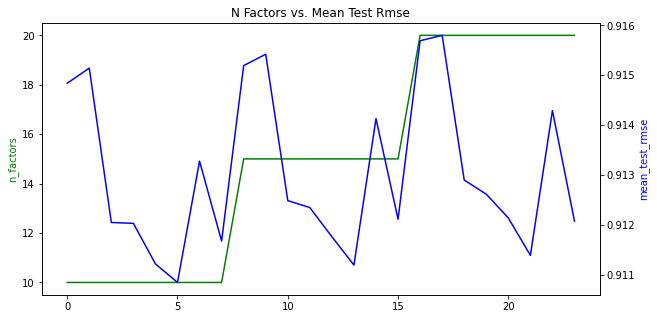

In [27]:
compare_metrics_chart(df_results, 'n_factors', 'mean_test_rmse')

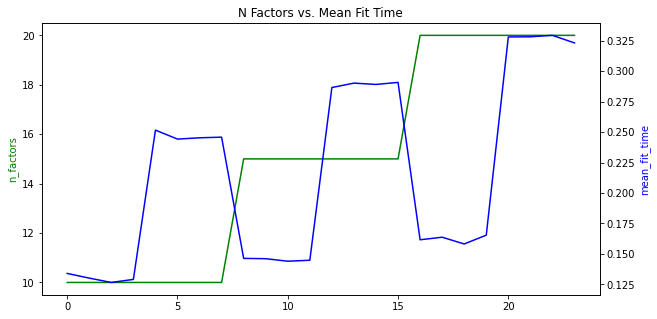

In [28]:
compare_metrics_chart(df_results, 'n_factors', 'mean_fit_time')

The lowest values for RMSE is reached regardless of the Number of Factors. It's arguable that we should have more factors to decrease RMSE since that's the expectation. However, it comes at a cost: fit time increase. Since the data is showing we can achieve low RMSE with only `10` factors then I'm going to choose that.

#### Number of Epochs

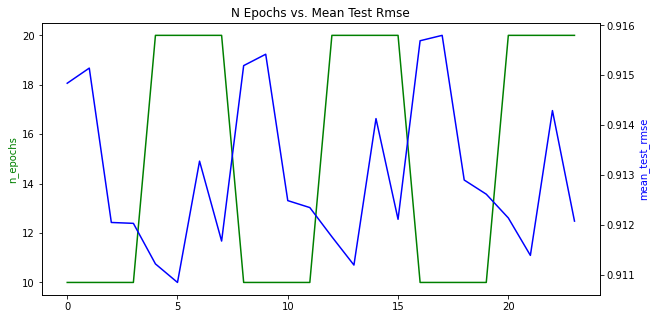

In [29]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_test_rmse')

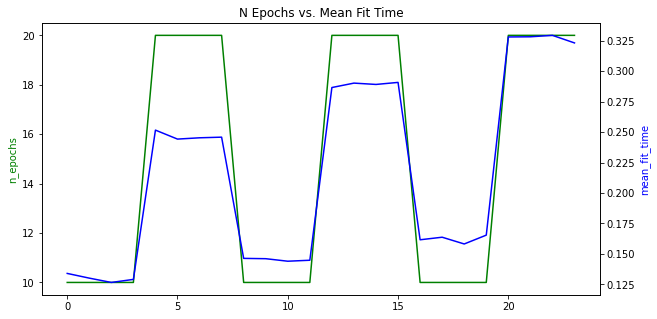

In [30]:
compare_metrics_chart(df_results, 'n_epochs', 'mean_fit_time')

The Number of Epochs reduces RMSE, but it's possible to see an increase of 50%-80% in Fit Time, which is more than the positive impact in RMSE. Therefore, I'll go with `20` epochs. 

#### Regularization Term

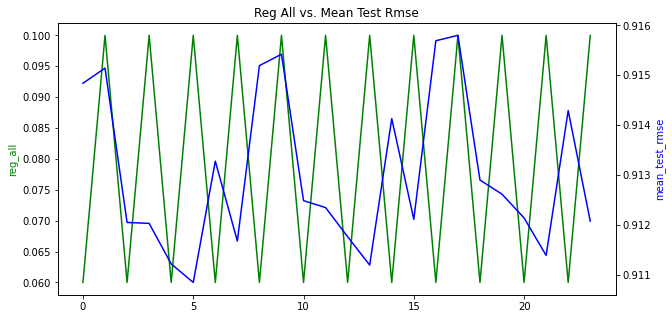

In [31]:
compare_metrics_chart(df_results, 'reg_all', 'mean_test_rmse')

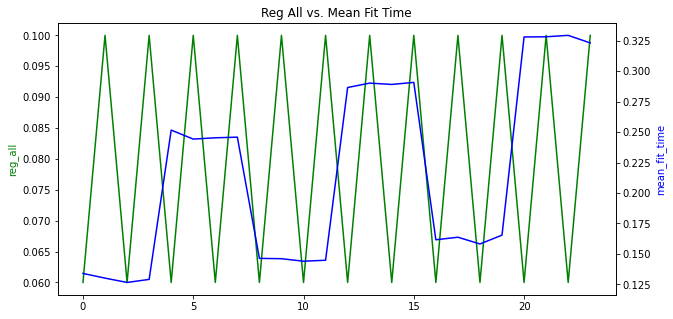

In [32]:
compare_metrics_chart(df_results, 'reg_all', 'mean_fit_time')

Low regularization term achieves better results with no impact in fit time.

#### Learning Rate

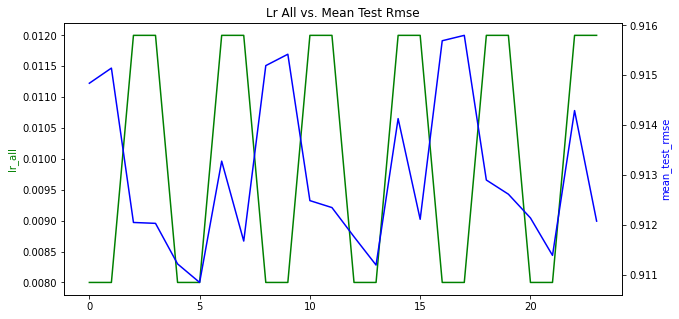

In [33]:
compare_metrics_chart(df_results, 'lr_all', 'mean_test_rmse')

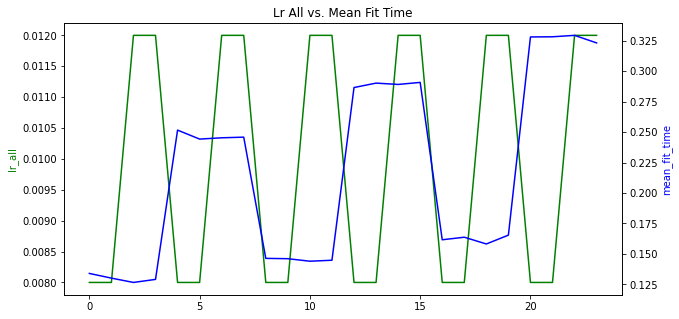

In [34]:
compare_metrics_chart(df_results, 'lr_all', 'mean_fit_time')

Having high Learning Rate has a positive impact in RMSE with now impact in Fit Time.

#### Final hyperparameters:
- `n_factors`: 15
- `n_epochs`: 20
- `lr_all`: 0.012
- `reg_all`: 0.06

### Try different models
#### Create a function to easily test different models

In [35]:
def full_model_training_evaluation(model, model_name, traindata, testdata):
    """
    Train and test different models and collect fit time and train/test RMSE.
    
    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        model_name(str): Model name created by the User. A way to identify the model.
        traindata(surprise.dataset.DatasetAutoFolds): Train dataset
        testdata(surprise.dataset.DatasetAutoFolds): Test dataset
        
    Returns:
        results(dict): A dictionary with the model name, fit time and RMSE's (train/test).
    """
    # Stor results in dictionary
    results = {}
    results['model_name'] = model_name
    print('Training', model_name, 'model')
    
    # Fit on train data
    start_time = time.time()
    model.fit(traindata.build_full_trainset())
    end_time = time.time()
    total_time = round(end_time - start_time, 2)
    results['fit_time_in_seconds'] = total_time
    
    # Get RMSE on train data
    predictions_train = model.test(traindata.build_full_trainset().build_testset())
    rmse_train = rmse(predictions_train, verbose=False).round(2)
    results['rmse_train'] = rmse_train
    
    # Get RMSE on test data
    predictions_test = model.test(testdata.build_full_trainset().build_testset())
    rmse_test = rmse(predictions_test, verbose=False).round(2)
    results['rmse_test'] = rmse_test
    
    return results

Instantiate different models

In [36]:
# Create SVD model with the best hyperparameters
svd = SVD(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [37]:
# SVD++: Use the same hyperparameters
svd_pp = SVDpp(n_factors=15, n_epochs=20, lr_all=0.012, reg_all=0.06, random_state=111)

In [38]:
# Different instances of KNN Basic models with different hyperparameters
knn_basic_person_baseline = KNNBasic(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_basic_person = KNNBasic(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_basic_cosine = KNNBasic(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [39]:
# Different instances of KNN Baseline models with different hyperparameters
knn_base_person_baseline = KNNBaseline(sim_options={'name':'pearson_baseline', 'user_based':True}, verbose=False)
knn_base_person = KNNBaseline(sim_options={'name':'pearson', 'user_based':True}, verbose=False)
knn_base_cosine = KNNBaseline(sim_options={'name':'cosine', 'user_based':True}, verbose=False)

In [40]:
# Put all models in a dictionary
models = {'SVD': svd,
          'SVD++': svd_pp,
          'KNNBasic Cosine': knn_basic_cosine,
          'KNNBasic Person': knn_basic_person,
          'KNNBasic Person Baseline': knn_basic_person_baseline,
          'KNNBaseline Cosine': knn_base_cosine,
          'KNNBaseline Person': knn_base_person,
          'KNNBaseline Person Baseline': knn_base_person_baseline}

In [41]:
# Loop through different models and evaluate them
model_results = []

for model_name, model_instance in models.items():
    results = full_model_training_evaluation(model_instance, model_name, traindata, testdata)
    model_results.append(results)

Training SVD model
Training SVD++ model
Training KNNBasic Cosine model
Training KNNBasic Person model
Training KNNBasic Person Baseline model
Training KNNBaseline Cosine model
Training KNNBaseline Person model
Training KNNBaseline Person Baseline model


### Model Evaluation:

In [42]:
pd.DataFrame(model_results)

,model_name,fit_time_in_seconds,rmse_train,rmse_test
0,SVD,0.40,0.70,0.90
1,SVD++,29.42,0.65,0.90
2,KNNBasic Cosine,0.08,0.80,1.04
3,KNNBasic Person,0.10,0.54,1.08
4,KNNBasic Person Baseline,0.07,0.09,1.09
5,KNNBaseline Cosine,0.10,0.73,0.94
6,KNNBaseline Person,0.12,0.47,0.97
7,KNNBaseline Person Baseline,0.07,0.08,0.98


#### Notes:
- **Fit Time**: `SVD++` is by far the worst model. All KNN models have somewhat the same Fit Time, which is 4 times faster than `SVD`. However, they are all very fast relative to the `SVD++` model.
- **RMSE Train**: The KNN Models using `person_baseline` is overfitting the train set. When comparing both Singular Value Decomposition models, the `SVD++` is performing better than the `SVD`.
- **RMSE Test**: Both Singular Value Decomposition models had the same performance numbers and performed better than all KNN models.

### Conclusion
I'll move forward with the `SVD` model given the fit time and RMSE scores.

## Create function to recommend movies to a new user + hint of a content-based
Finally, I'm going to create a function that takes a genre and ratings from a user who has no ratings in the dataset. In the process, I'm going to focus my recommendations based on the chosen genre (content-based part of the recommendation).

In [43]:
# Create list of genres
list_of_genres = stacked_genres['genre'].sort_values().unique()[1:]

In [44]:
# Combine mean ratings and movies details
ratings_movies_df = pd.merge(mean_ratings_df, df_movies, on='movieId')

#### Filter the dataset by removing movies with not enough ratings

In [45]:
def filtered_dataset(genre):
    """
    Function to filter the dataset given the genre and remove outliers.
    
    Args:
        genre(str): The genre the user has chosen to come with recommendations.
        
    Returns:
        genre_df(pd.DataFrame): Filtered Dataframe with only the chosen genre.
    """
    # Keep only the selected genre
    genre_df = ratings_movies_df[ratings_movies_df['genres'].str.contains(genre)]
    
    # Calculate the 95th quantile and the weighted rating
    minimum_no_of_ratings = genre_df['count_rating'].quantile(0.95)
    genre_df['minimum_no_of_ratings'] = minimum_no_of_ratings
    genre_df['weighted_rating'] = genre_df.apply(weighted_rating, axis=1)
    
    # Remove movies with not enough ratings
    genre_df = genre_df[genre_df['count_rating'] >= minimum_no_of_ratings]
    
    # Sorted it by weighted rating so we have the highest ratings on the top
    genre_df = genre_df.sort_values('weighted_rating', ascending=False)
    genre_df = genre_df.reset_index(drop=True)

    # Keep certain relevant columns
    genre_df = genre_df[['movieId', 'title', 
                         'genres', 'count_rating', 
                         'minimum_no_of_ratings', 'weighted_rating']]

    return genre_df

#### Create first a function to let the user rate five movies

In [46]:
def rate_movie(n_of_movies=5, default_user_id=9999999):
    """
    Function to request a new user to review some movies.
    
    Args:
        n_of_movies(int): Number of ratings the new will have to give.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.
        
    Returns:
        new_ratings_df(pd.DataFrame): Pandas Dataframe with the new ratings
        favorite_genre(str): The User's favorite genre
    """
    # Print a list of the available genres
    print('List of Available Genres: ', ", ".join(list_of_genres))
    
    # Gather input from user on which genre will be analyzed
    favorite_genre = input('Choose one genre from the following (case-sensitive): ')
    
    # Filter the dataset
    df_movies_popularity = filtered_dataset(favorite_genre)
    
    # Keep only movies that contain the chosen genre
    favorite_genre_movies = df_movies_popularity[df_movies_popularity['genres'].str.contains(favorite_genre)]
    
    # Keep the highest rated movies
    favorite_genre_movies = favorite_genre_movies.iloc[:20].sample(frac=1, random_state=111)
    favorite_genre_movies = favorite_genre_movies.iloc[:n_of_movies]
    print('')
    
    # Created to store ratings from user
    ratings_list = []
    
    # Loop through dataframe with movies to be rated
    for row in favorite_genre_movies.iterrows():
        # Extract Title and ID
        movie_title = row[1]['title']
        movie_id = row[1]['movieId']
        
        print('Movie to rate: ', movie_title)
        
        # Gather rating from user
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        
        # Deal with users not typing a number and create a new variable with the integer
        try:
            rating_int = int(rating)
        except:
            rating_int = 1
        
        # While the Rating is not valid, keep asking the user
        while (rating != 'n') and not (1 <= rating_int <=5):
            rating = input('Please rate the movie between 1-5 or n if you have not seen : \n')
        else:
            # If the rating is different from 'n' then we need to add the rating to the list
            if rating != 'n':        
                ratings_list.append({'userId': default_user_id,
                                    'movieId': movie_id,
                                    'rating': rating_int})
        print('')
        
    # Convert to DataFrame
    new_ratings_df = pd.DataFrame(ratings_list)
    
    return new_ratings_df, favorite_genre, df_movies_popularity

#### Create a function to give the recommendations

In [47]:
def give_n_recommendations(model, default_user_id=9999999, n_recommendations=5):
    """
    Function to request a new user to review movies and give recommendations based on that.
    
    Args:
        model(surprise.prediction_algorithms): Model instances from the surprise package.
        default_user_id(int): Random user id that will be given to the user to be able to reference to it later.
        n_recommendations(int): Number of recommendations that will be given to the user.
    """
    # Extract ratings from the user
    new_ratings_df, favorite_genre, df_movies_popularity = rate_movie(default_user_id=default_user_id)
    watched_movies_id = new_ratings_df['movieId']
    
    ## add the new ratings to the original ratings DataFrame
    updated_df = pd.concat([new_ratings_df, df_ratings_clean])
    new_data = Dataset.load_from_df(updated_df, reader)
    new_dataset = new_data.build_full_trainset()
    
    # Fit new dataset
    model.fit(new_dataset)
    
    # make predictions for the user
    results = []
    for movie_id in df_movies_popularity['movieId'].unique():
        predicted_score = model.predict(default_user_id, movie_id)[3]
        results.append((movie_id, predicted_score))
        
    # order the predictions from highest to lowest rated
    ranked_movies = pd.DataFrame(results, columns=['movieId', 'predicted_score'])
    ranked_movies = ranked_movies[~ranked_movies['movieId'].isin(watched_movies_id)]
    ranked_movies = ranked_movies.sort_values('predicted_score', ascending=False).reset_index(drop=True)
    ranked_movies = pd.merge(ranked_movies, df_movies, on='movieId')
    # ranked_movies = ranked_movies[ranked_movies['genres'].str.contains(favorite_genre)]
    
    print('The recommendations are the following:')
    if len(ranked_movies) < n_recommendations:
        n_recommendations = len(ranked_movies)
    for row in range(n_recommendations):
        movie_id = ranked_movies.iloc[row]['movieId']
        recommended_title = df_movies[df_movies['movieId'] == movie_id]['title'].item()
        print(f'No. {row+1} is {recommended_title}')

#### Let's test it out!
I'm going to try different genres to see how the model behaves.
#### `Action`

In [48]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Action

Movie to rate:  Star Wars: Episode V - The Empire Strikes Back (1980)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
1

Movie to rate:  Dark Knight, The (2008)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Inception (2010)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Apocalypse Now (1979)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Blade Runner (1982)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

The recommendations are the following:
No. 1 is Lord of the Rings: The Return of the King, The (2003)
No. 2 is Fight Club (1999

#### `Documentary`

In [49]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Documentary

Movie to rate:  Inside Job (2010)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Roger & Me (1989)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Corporation, The (2003)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3

Movie to rate:  Sicko (2007)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2

The recommendations are the following:
No. 1 is Hoop Dreams (1994)
No. 2 is Crumb (1994)
No. 3 is Fog of War: Eleven Less

#### `Crime`

In [50]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Crime

Movie to rate:  Godfather, The (1972)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Silence of the Lambs, The (1991)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Green Mile, The (1999)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Fargo (1996)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Inception (2010)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

The recommendations are the following:
No. 1 is Shawshank Redemption, The (1994)
No. 2 is Fight Club (1999)
No. 3 is Departed, The (2006)
No. 4 is Goodfellas

#### `Romance`

In [51]:
give_n_recommendations(svd)

List of Available Genres:  Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western
Choose one genre from the following (case-sensitive): Romance

Movie to rate:  Casablanca (1942)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  American Beauty (1999)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5

Movie to rate:  Shrek (2001)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2

Movie to rate:  Graduate, The (1967)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

Movie to rate:  Lost in Translation (2003)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n

The recommendations are the following:
No. 1 is Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
No. 2 is Eternal Sunshine of the Spotless Mind (2004)
No. 3 

# Conclusion
I'm happy with the results. However, I think the function is a bit limited. I'd like to have the recommender in an app. To do that, I'm going to use Streamlit.

## Streamlit
I'm going to export some files so I can use them in Streamlit

In [53]:
# Export it to use it on streamlit
ratings_movies_df.to_csv('./app/data/movies_by_rating.csv', index=0)
df_ratings_clean.to_csv('./app/data/user_movie_ratings.csv', index=0)
dump.dump('./app/data/svd.pkl', algo=svd)

# [Check out the App!](https://movie-recommender-reno.herokuapp.com/)

# Improvements
- Use Normalized Discounted Cumulative Gain (NDCG) to evaluate models.
- Develop a Content-Based layer using `tags` and `genres` or even `title`/`year`.
    - Sometimes I rate Star Wars with 1 star and the recommender outputs more Start Wars movies.